# Examples on how to fetch astronomical survey data

## SDSS Imaging Data

The total volume of this dataset is measured in teans of terabytes, for this notebook, it will be limited to a small patch of the sky (0.05% of the sky). 
The following SQL query 

In [1]:
sdss_query = '''
SELECT
    ROUND(p.ra, 6) AS ra,
    ROUND(p.dec, 6) AS dec,
    p.run,
    ROUND(p.extinction_r, 3) AS rExtSFD,     -- r band extinction from SFD
    ROUND(p.modelMag_u, 3) AS uRaw,          -- ISM-uncorrected model mags
    ROUND(p.modelMag_g, 3) AS gRaw,          -- rounding up model maginitudes
    ROUND(p.modelMag_r, 3) AS rRaw,
    ROUND(p.modelMag_i, 3) AS iRaw,
    ROUND(p.modelMag_z, 3) AS zRaw,
    ROUND(p.modelMagErr_u, 3) AS uErr,        -- errors are important
    ROUND(p.modelMagErr_g, 3) AS gErr,
    ROUND(p.modelMagErr_r, 3) AS rErr,
    ROUND(p.modelMagErr_i, 3) AS iErr,
    ROUND(p.modelMagErr_z, 3) AS zErr,
    ROUND(p.psfMag_u, 3) AS uRawPSF,          -- psf Magnitudes
    ROUND(p.psfMag_g, 3) AS gRawPSF,
    ROUND(p.psfMag_r, 3) AS rRawPSF,
    ROUND(p.psfMag_i, 3) AS iRawPSF,
    ROUND(p.psfMag_z, 3) AS zRawPSF,
    ROUND(p.psfMagErr_u, 3) AS upsfErr,
    ROUND(p.psfMagErr_g, 3) AS gpsfErr,
    ROUND(p.psfMagErr_r, 3) AS rpsfErr,
    ROUND(p.psfMagErr_i, 3) AS ipsfErr,
    ROUND(p.psfMagErr_z, 3) AS zpsfErr,
    p.type,                                    -- tells if a source is resolved or not
    (CASE WHEN (p.flags & '16') = 0 then 1 else 0) AS ISOLATED
INTO mydb.SDSSImagingSample
FROM PhotoTag p
WHERE
    p.ra > 0.0 AND p.ra < 10.0 AND p.dec > -1 AND p.dec < 1 -- 10x2 sq.deg
    AND (p.type = 3 OR p.type = 6) -- resolved and unresolved sources
    AND (p.flags & '4295229440') = 0 -- '4295229440' is a magic code for no DEBLENDED_AS_MOVING or SATURATED objects
    AND p.mode = 1 -- PRIMARY objects only, which implies !BRIGHT && (!BLENDED || NODEBLEND || nchild == 0)
    AND p.modelMag_r < 22.5 -- adopted faint limit (same as about SDSS limit)
'''

This query can be copied into the SQL window at the CasJobs site. After running it, there will be a SDSSImagingSample dataset available for download.

The query selects objects from the PhotoTag table (which includes a subset of the most popular data columns from the main table PhotoObjAll). Detailed decription of all listed parameters in all the available tables can be found at the CAS site. The subset of PhotoTag parameters returned by the above query includes positions, interstellar dust extinction in the r band, and the five SDSS magnitudes with errors in two flavors. There are several types of magnitudes measured by SDSS and the so-called model amgnitudes work well for both inresolved and resolved soruces.

The WHERE clause first limits the returned data to a 20deg^2 (0.05% of the sky) patch of the sky, and then use several conditions to select unique stationary and well-measured sources above the chosen faint limit. The most mysterious part of this query is the use of processing flags.

## AstroML Data Set tools

Datasets are mantained on a webpage with access via http. Each dataset is downloaded to the local machine only on the first call to the associate function

### SDSS Imaging Data

To facilitate the use of the data from the SQL query above, the AstroML library provides the following function to fetch this data

In [2]:
from astroML.datasets import fetch_imaging_sample

In [3]:
data = fetch_imaging_sample()

In [4]:
type(data)

numpy.ndarray

In [5]:
data.shape

(330753,)

In [6]:
data.dtype.names[:5]

('ra', 'dec', 'run', 'rExtSFD', 'uRaw')

In [7]:
data['ra'][:5]

array([0.358174, 0.358382, 0.357898, 0.35791 , 0.358881])

In [8]:
data['dec'][:5]

array([-0.508718, -0.551157, -0.570892, -0.426526, -0.505625])

### Fetching and displaying SDSS spectra

astroML contains this function that provides a real-time interface to FITS files of SDSS spectroscopic images

In [9]:
import matplotlib.pyplot as plt

In [10]:
from astroML.datasets import fetch_sdss_spectrum

In [11]:
plate = 1615 # plate number of the spectrum

In [12]:
mjd = 53166 # modified julian date

In [13]:
fiber = 513 # fiber ID on a given plate

In [14]:
data = fetch_sdss_spectrum(plate, mjd, fiber)

Text(0, 0.5, 'Flux')

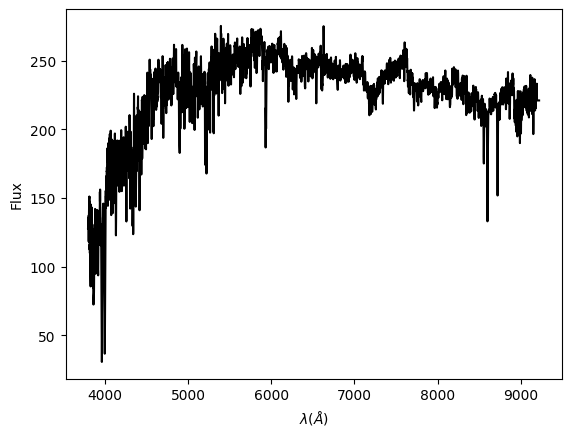

In [15]:
ax = plt.axes()
ax.plot(data.wavelength(), data.spectrum, '-k')
ax.set_xlabel(r'$\lambda (\AA)$')
ax.set_ylabel('Flux')

An example of an SDSS spectrum (the specific flux plotted as a function of wavelength) fetched from the SDSS Data Archive Server in real time using Python tools provided here

### Galaxies with SDSS Spectroscopic data

This dataset contains a selected subset of about a million galaxies for spectroscopic follow-up, including the main flux-limited sample and a smaller color-selected sample designed to include very luminous and distant galaxies.

In [16]:
from astroML.datasets import fetch_sdss_specgals

In [17]:
data = fetch_sdss_specgals()

In [18]:
data.shape

(661598,)

In [19]:
data.dtype.names[:5]

('ra', 'dec', 'mjd', 'plate', 'fiberID')

In [20]:
data = data[:10000]

In [21]:
u = data['modelMag_u']

In [22]:
r = data['modelMag_r']

In [23]:
rPetro = data['petroMag_r']

Text(0, 0.5, '$r_{petrosian}$')

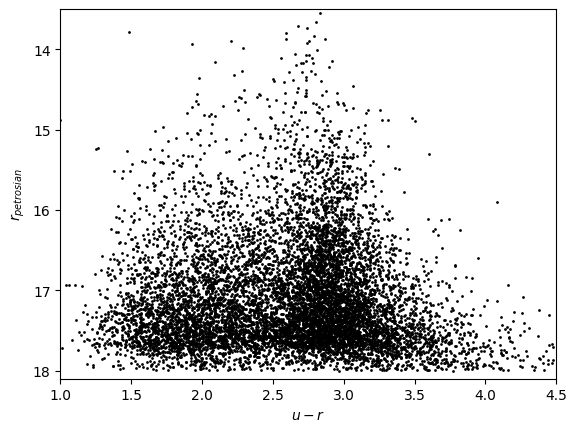

In [24]:
ax = plt.axes()
ax.scatter(u-r, rPetro, s=4, lw=0, c='k')
ax.set_xlim(1, 4.5)
ax.set_ylim(18.1, 13.5)
ax.set_xlabel('$u - r$')
ax.set_ylabel('$r_{petrosian}$')

The r vs. u -- r color-magnitude diagram for the first 10,000 entries in the catalog of spectroscopically observed galaxies from the Sloan Digital Sky Survey (SDSS). Note two "clouds" of points with different morphologies separated by u - r ≈ 2.3. The abrupt decrease of the point density for r > 17.7 (the bottom of the diagram) is due to the selection function for the spectroscopic galaxy sample from SDSS

### SDSS DR7 Quasar Catalog

This dataset contains 105,783 spectroscopically confirmed quasars with high realiable redshifts, and represents the largest available dataset of this type.

In [25]:
from astroML.datasets import fetch_dr7_quasar

In [26]:
data = fetch_dr7_quasar()

In [27]:
data.shape

(105783,)

In [28]:
data.dtype.names[:5]

('sdssID', 'RA', 'dec', 'redshift', 'mag_u')

In [29]:
data = data[:10000]

In [30]:
r = data['mag_r']
i = data['mag_i']
z = data['redshift']

Text(0, 0.5, 'r-i')

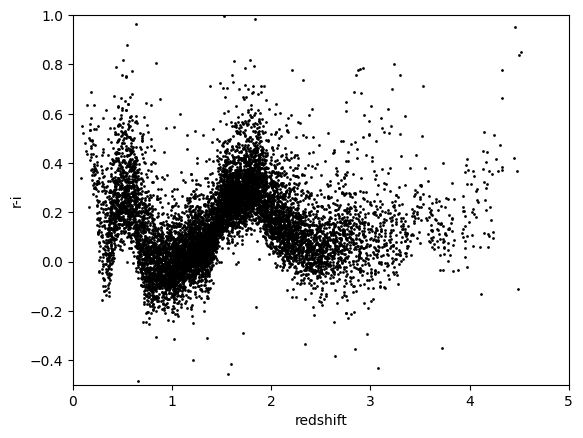

In [31]:
ax = plt.axes()
ax.scatter(z, r - i, s=4, c='black', linewidth=0)
ax.set_xlim(0, 5)
ax.set_ylim(-0.5, 1.0)
ax.set_xlabel('redshift')
ax.set_ylabel('r-i')

The r-i color vs. redshift diagram for the first 10,000 entries from the SDSS Data Release 7 Quasar Catalog. The color variation is due to emission lines entering and exiting the r and i wavelength windows